In [116]:
import pandas as pd, matplotlib.pyplot as plt, re, zipfile
from sklearn.preprocessing import LabelEncoder

DIR_NAME = '../Data/'
ZIP_FILE = 'transactions.zip'
FILE_NAME = 'transactions.txt'
with zipfile.ZipFile(DIR_NAME+ZIP_FILE, 'r') as zip_ref:
    zip_ref.extractall(DIR_NAME)

df = pd.read_json(DIR_NAME+FILE_NAME, lines=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  int64  
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                786363 non-null  object 
 8   merchantCountryCode       786363 non-null  object 
 9   posEntryMode              786363 non-null  object 
 10  posConditionCode          786363 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

#### There are no NA values in the dataset that we need to impute/account for

In [117]:
df.isna().sum()

accountNumber               0
customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
echoBuffer                  0
currentBalance              0
merchantCity                0
merchantState               0
merchantZip                 0
cardPresent                 0
posOnPremises               0
recurringAuthInd            0
expirationDateKeyInMatch    0
isFraud                     0
dtype: int64

In [118]:
df.nunique()

accountNumber                 5000
customerId                    5000
creditLimit                     10
availableMoney              521915
transactionDateTime         776637
transactionAmount            66038
merchantName                  2490
acqCountry                       5
merchantCountryCode              5
posEntryMode                     6
posConditionCode                 4
merchantCategoryCode            19
currentExpDate                 165
accountOpenDate               1820
dateOfLastAddressChange       2184
cardCVV                        899
enteredCVV                     976
cardLast4Digits               5245
transactionType                  4
echoBuffer                       1
currentBalance              487318
merchantCity                     1
merchantState                    1
merchantZip                      1
cardPresent                      2
posOnPremises                    1
recurringAuthInd                 1
expirationDateKeyInMatch         2
isFraud             

### Defining the *Levenshtein dissimilarity metric* when there's a cvv-mismatch case

Rather than just binary non-equality, check score of mismatch: a single digit wrong might be just a minor blunder.

In [119]:
import numpy as np
def levenshtein_distance(s1, s2):
    r = len(s1)+1
    c = len(s2)+1
    distance = np.zeros((r,c),dtype = int)

    for i in range(1, r):
        for k in range(1,c):
            distance[i][0] = i
            distance[0][k] = k
            
    for col in range(1, c):
        for row in range(1, r):
            if s1[row-1]==s2[col-1]:
                cost = 0
            else:
                cost = 2
            distance[row][col] = min(distance[row-1][col] + 1,      # Cost of deletions
                                 distance[row][col-1] + 1,          # Cost of insertions
                                 distance[row-1][col-1] + cost)     # Cost of substitutions
    return distance[row][col] / (len(s1)+len(s2))



### Engineer some time-dependent features and one for anomolous card-entry

In [120]:
def add_time_dependent_features(df, col, include_time_fields=False):
    df[col+'Year'] = df[col].dt.year
    df[col+'Month'] = df[col].dt.month
    df[col+'Day'] = df[col].dt.day
    df[col+'DayOfWeek'] = df[col].dt.weekday
    df[col+'Date'] = df[col].dt.date
    if include_time_fields:
        df[col+'Hour'] = df[col].dt.hour
        df[col+'Min'] = df[col].dt.minute
    df = df.drop(col, axis=1)
    return df

df['transactionDt'] = pd.to_datetime(df['transactionDateTime'])
add_time_dependent_features(df, 'transactionDt', True)

df['accountOpenDt'] = pd.to_datetime(df['accountOpenDate'])
df = add_time_dependent_features(df, 'accountOpenDt')

df['lastAddressChangeDt'] = pd.to_datetime(df['dateOfLastAddressChange'])
df = add_time_dependent_features(df, 'lastAddressChangeDt')

#df['cvvMismatch'] = df['cardCVV']!=df['enteredCVV']
# Rather than just binary non-equality, check score of mismatch: a single digit wrong might be just a minor blunder
df['cardCVV'] = df['cardCVV'].astype(str)
df['enteredCVV'] = df['enteredCVV'].astype(str)
df['cvvMismatchScore'] = df.apply(lambda x : levenshtein_distance(x.cardCVV, x.enteredCVV), axis=1)

KeyboardInterrupt: 

### Remove the features which have just one categorical value

In [ ]:
nvalue_counts_df = df.nunique()
columns_to_drop = nvalue_counts_df.index[nvalue_counts_df.values==1]
print(f'Columns that will be dropped: {columns_to_drop.values}')


main_df = df.copy(deep=True)
main_df = main_df.drop(labels=columns_to_drop, axis=1)

Columns that will be dropped: ['echoBuffer' 'merchantCity' 'merchantState' 'merchantZip' 'posOnPremises'
 'recurringAuthInd' 'transactionDtYear']


## 4 Transaction types
> `Address-verification` (of course) is done without any payment

> `Purchases` and `Reversals` have a wide range of payment-amounts transacted

> There's also a blank string which we'll impute with `UNK`

In [ ]:
main_df['transactionType'] = main_df['transactionType'].replace(r'^\s*$', 'UNK', regex=True)

main_df[['transactionAmount','transactionType']].groupby(by=['transactionType'], as_index=False).agg({'transactionAmount':['count','nunique','min','max']})

transactionType transactionAmount                       
                                    count nunique   min      max
0  ADDRESS_VERIFICATION             20169       1  0.00     0.00
1              PURCHASE            745193   66011  0.00  2011.54
2              REVERSAL             20303   14450  0.00  1435.64
3                   UNK               698     685  0.11  1135.64

In [ ]:
import plotly.express as px
fig = px.histogram( main_df, x='transactionAmount', color='transactionType', title='Histograms of Trans-Amts for different Trans-types' )
fig.show()

print('!!! We see Power-law distributions with long right tails. Most transactions have low amounts. !!!')

### Identifying reversal transactions that might've occured after disputes

We'll be looking at pairwise transactions captured for a customer at a specific merchant.

Our final report will contain:

> The first-transaction being `PURCHASE` and the second must be marked as `REVERSAL`

> Both transactions will be for the same customer at the same merchant, and of the same amount.

In [ ]:
get_shifted_column = lambda df, colname : df.groupby(by=['customerId'], as_index=False)[[colname]].shift(-1)

REVERSAL_COLS_TO_VIEW = ['customerId','transactionDtDate','transactionAmount','merchantName','transactionType','cardPresent','isFraud']

COLNAMES_T1_VS_T2 = {
    'transactionAmount' : 'nextTransAmt',
    'transactionDtDate' : 'nextTransDate',
    'merchantName' : 'nextMerchantName',
    'transactionType' : 'nextTransType',
    'isFraud' : 'nextIsFraud'
}

rev_trans_df = main_df[REVERSAL_COLS_TO_VIEW].sort_values(by=['customerId','merchantName','transactionAmount','transactionDtDate'])

for col, newcol in COLNAMES_T1_VS_T2.items():
    rev_trans_df[newcol] = get_shifted_column(rev_trans_df, col)


rev_trans_df['durationBetweenTrans'] = rev_trans_df[COLNAMES_T1_VS_T2['transactionDtDate']] - rev_trans_df['transactionDtDate']
rev_trans_df['durationBetweenTrans'] = (rev_trans_df['durationBetweenTrans'] / np.timedelta64(1, 'D')).convert_dtypes('int')


reversals_df = rev_trans_df[
    (rev_trans_df['merchantName']==rev_trans_df[COLNAMES_T1_VS_T2['merchantName']])
    &
    (rev_trans_df['transactionType']=='PURCHASE') & (rev_trans_df[COLNAMES_T1_VS_T2['transactionType']]=='REVERSAL')
    &
    (rev_trans_df['transactionAmount']==rev_trans_df[COLNAMES_T1_VS_T2['transactionAmount']])
    ]

reversals_df

,customerId,transactionDtDate,transactionAmount,merchantName,transactionType,cardPresent,isFraud,nextTransAmt,nextTransDate,nextMerchantName,nextTransType,nextIsFraud,durationBetweenTrans
541963,100088067,2016-11-20,22.32,AMC #79863,PURCHASE,True,False,22.32,2016-11-20,AMC #79863,REVERSAL,False,0
87919,100328049,2016-01-15,43.74,Lyft,PURCHASE,False,False,43.74,2016-01-15,Lyft,REVERSAL,False,0
87935,100328049,2016-03-24,284.97,McDonalds #423357,PURCHASE,True,False,284.97,2016-03-26,McDonalds #423357,REVERSAL,False,2
151496,100737756,2016-05-30,93.67,34th BBQ #436606,PURCHASE,True,False,93.67,2016-06-06,34th BBQ #436606,REVERSAL,False,7
151534,100737756,2016-08-11,501.29,Best Bistro #262998,PURCHASE,True,False,501.29,2016-08-24,Best Bistro #262998,REVERSAL,False,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
545580,999258704,2016-09-02,72.93,gap.com,PURCHASE,False,False,72.93,2016-09-02,gap.com,REVERSAL,False,0
670027,999283629,2016-04-09,247.40,Delta Airlines,PURCHASE,False,False,247.40,2016-05-01,Delta Airlines,REVERSAL,False,22
670108,999283629,2016-11-14,150.58,Franks Sandwitch Bar,PURCHASE,True,False,150.58,2016-11-19,Franks Sandwitch Bar,REVERSAL,False,5
670051,999283629,2016-06-01,96.56,Lyft,PURCHASE,False,False,96.56,2016-06-07,Lyft,REVERSAL,False,6


In [ ]:
fig = px.box(
    reversals_df, y='durationBetweenTrans', color='isFraud',
    title='Boxplots for duration between Purchase and Reversal transactions'
    )
fig.show()
print('!!! Certainly a Fraudulent transaction is reported and its reversal is performed quicker !!!')

In [ ]:
reversals_df[(reversals_df['customerId']==999283629)]

,customerId,transactionDtDate,transactionAmount,merchantName,transactionType,cardPresent,isFraud,nextTransAmt,nextTransDate,nextMerchantName,nextTransType,nextIsFraud,durationBetweenTrans
670027,999283629,2016-04-09,247.40,Delta Airlines,PURCHASE,False,False,247.40,2016-05-01,Delta Airlines,REVERSAL,False,22
670108,999283629,2016-11-14,150.58,Franks Sandwitch Bar,PURCHASE,True,False,150.58,2016-11-19,Franks Sandwitch Bar,REVERSAL,False,5
670051,999283629,2016-06-01,96.56,Lyft,PURCHASE,False,False,96.56,2016-06-07,Lyft,REVERSAL,False,6
670084,999283629,2016-09-15,407.23,apple.com,PURCHASE,False,False,407.23,2016-10-03,apple.com,REVERSAL,False,18


*Example of a reversal scenario:*
* Customer purchases apple product worth $407.23, realizes doesn't need item or was a mistake, returns immediately.

### Identifying multi-swipe transactions that might've occured accidentally on the same day

For the same candidate-key (`accountNumber`,`merchantName`) if we see 2 or more transactions occured with same amount, then it's likely to be a multi-swipe situation that isn't outright fraud.

In [ ]:
# SELECT ACC, MERCHANT WHERE [ACC,MERCHANT] TRANSACTION_TYPE!="REVERSAL" AND SAME TRANSACTIONAMOUNT ON SAME DAY
transactions_without_reversals = main_df[(main_df['transactionType']!='REVERSAL') & main_df['cardPresent']==True]

transactions_without_reversals = transactions_without_reversals.groupby(
    by=['customerId','merchantName','transactionDtDate'], as_index=False).agg(
        { 'transactionAmount': ['nunique', 'count'] })

transactions_without_reversals.columns = ['customerId','merchantName','transactionDate','transAmtNunique','transAmtCnt']

multiswipes_df = transactions_without_reversals[
    (transactions_without_reversals['transAmtNunique']==1) & 
    (transactions_without_reversals['transAmtCnt']>1)
    ].sort_values(by=['customerId','merchantName','transactionDate'])

multiswipes_df

,customerId,merchantName,transactionDate,transAmtNunique,transAmtCnt
165,100737756,34th BBQ #166379,2016-07-10,1,2
230,100737756,Franks Deli,2016-01-18,1,3
284,100737756,South Steakhouse #73819,2016-07-02,1,2
338,101132326,Regal Cinemas #05791,2016-08-24,1,2
598,102038975,KFC #304124,2016-05-09,1,2
...,...,...,...,...,...
335407,998801944,Popeyes #414406,2016-06-24,1,2
335421,998801944,Quizno's #784044,2016-07-11,1,2
335433,998801944,Subway #671015,2016-10-12,1,2
335440,998801944,Tim Hortons #726208,2016-07-02,1,2


In [ ]:
view_cols = ['accountNumber','merchantName','transactionAmount','transactionDateTime','cardPresent','isFraud','transactionType']
main_df[
    (main_df['accountNumber']==100737756) & 
    (main_df['merchantName']=='34th BBQ #166379')][view_cols].sort_values(
    by=['transactionDateTime'])

,accountNumber,merchantName,transactionAmount,transactionDateTime,cardPresent,isFraud,transactionType
151447,100737756,34th BBQ #166379,272.00,2016-02-23T14:11:06,True,False,PURCHASE
151517,100737756,34th BBQ #166379,43.25,2016-07-10T14:31:07,True,False,PURCHASE
151518,100737756,34th BBQ #166379,43.25,2016-07-10T14:32:06,True,False,PURCHASE
151575,100737756,34th BBQ #166379,331.72,2016-11-05T17:50:30,True,True,PURCHASE


*Example of a multi-swipe scenario:*
* Customer frequently visits "34th BBQ" restaurant, but on 10th July 2016, 2 transactions occured within a few seconds of each other.
* Neither were reported to be fraudulent.

.

## Moving on to statistical EDA of the dataset

### Describe the numerical columns and plot histograms to view distributions
All numerical-features seem to follow a power-distribution. Ignore the master-data fields like customerId, accountNumber, credit-card details, etc.

In [ ]:
main_df.describe()

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,cardLast4Digits,currentBalance,transactionDtMonth,transactionDtDay,transactionDtDayOfWeek,...,transactionDtMin,accountOpenDtYear,accountOpenDtMonth,accountOpenDtDay,accountOpenDtDayOfWeek,lastAddressChangeDtYear,lastAddressChangeDtMonth,lastAddressChangeDtDay,lastAddressChangeDtDayOfWeek,cvvMismatchScore
count,7.863630e+05,7.863630e+05,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,...,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.00000,786363.000000
mean,5.372326e+08,5.372326e+08,10759.464459,6250.725369,136.985791,4757.417799,4508.739089,6.648343,15.732804,3.002529,...,29.518682,2013.548618,7.043133,15.917197,3.082027,2014.804087,6.286028,15.476674,2.99443,0.003346
std,2.554211e+08,2.554211e+08,11636.174890,8880.783989,147.725569,2996.583810,6457.442068,3.436256,8.780564,1.995858,...,17.325778,1.872314,3.378144,8.752827,1.949832,1.881635,3.373176,8.591262,1.96869,0.037934
min,1.000881e+08,1.000881e+08,250.000000,-1005.630000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,1989.000000,1.000000,1.000000,0.000000,1989.000000,1.000000,1.000000,0.00000,0.000000
25%,3.301333e+08,3.301333e+08,5000.000000,1077.420000,33.650000,2178.000000,689.910000,4.000000,8.000000,1.000000,...,15.000000,2013.000000,4.000000,8.000000,1.000000,2014.000000,3.000000,8.000000,1.00000,0.000000
50%,5.074561e+08,5.074561e+08,7500.000000,3184.860000,87.900000,4733.000000,2451.760000,7.000000,16.000000,3.000000,...,30.000000,2014.000000,7.000000,16.000000,3.000000,2016.000000,6.000000,15.000000,3.00000,0.000000
75%,7.676200e+08,7.676200e+08,15000.000000,7500.000000,191.480000,7338.000000,5291.095000,10.000000,23.000000,5.000000,...,45.000000,2015.000000,10.000000,23.000000,5.000000,2016.000000,9.000000,23.000000,5.00000,0.000000
max,9.993896e+08,9.993896e+08,50000.000000,50000.000000,2011.540000,9998.000000,47498.810000,12.000000,31.000000,6.000000,...,59.000000,2015.000000,12.000000,31.000000,6.000000,2016.000000,12.000000,31.000000,6.00000,1.000000


In [ ]:
for col in ['availableMoney', 'transactionAmount', 'currentBalance']:
    fig = px.histogram(main_df, x=col, facet_col='isFraud', color='isFraud', title=f'{col.capitalize()} for Legitimate vs Fraudulent Transactions. *Facet-scales are different!')
    fig.update_yaxes(matches=None)
    fig.show()

### There are just 12,417 cases of Fraud in our dataset of 786,363

In [ ]:
count_frauds = main_df['isFraud'].value_counts()
print(f'The dataset contains {round(count_frauds[True]/count_frauds[False]*100,2)}% of fraudulent cases.')

The dataset contains 1.6% of fraudulent cases.


### Replace boolean-values with binary 0/1 instead
If True --> 1, otherwise 0.

In [ ]:
boolean_columns = main_df.select_dtypes(include='bool').columns

for col in boolean_columns:
    main_df[col] = main_df[col].replace(True, 1).replace(False, 0)

In [ ]:
categorical_cols = set(main_df.select_dtypes(include='object').columns)
categorical_cols -= set(['transactionDateTime', 'accountOpenDate', 'dateOfLastAddressChange', 'currentExpDate'])
main_df[categorical_cols]

,posConditionCode,transactionDtDate,enteredCVV,accountOpenDtDate,posEntryMode,merchantCategoryCode,merchantCountryCode,merchantName,transactionType,lastAddressChangeDtDate,acqCountry,cardCVV
0,01,2016-08-13,414,2015-03-14,02,rideshare,US,Uber,PURCHASE,2015-03-14,US,414
1,01,2016-10-11,486,2015-03-14,09,entertainment,US,AMC #191138,PURCHASE,2015-03-14,US,486
2,01,2016-11-08,486,2015-03-14,09,mobileapps,US,Play Store,PURCHASE,2015-03-14,US,486
3,01,2016-12-10,486,2015-03-14,09,mobileapps,US,Play Store,PURCHASE,2015-03-14,US,486
4,01,2016-03-24,885,2015-08-06,02,fastfood,US,Tim Hortons #947751,PURCHASE,2015-08-06,US,885
...,...,...,...,...,...,...,...,...,...,...,...,...
786358,01,2016-12-22,936,2012-08-23,90,rideshare,US,Lyft,PURCHASE,2012-08-23,US,936
786359,01,2016-12-25,939,2012-08-23,09,online_subscriptions,US,hulu.com,PURCHASE,2012-08-23,US,939
786360,01,2016-12-27,936,2012-08-23,02,rideshare,US,Lyft,PURCHASE,2012-08-23,US,936
786361,99,2016-12-29,939,2012-08-23,09,online_retail,US,walmart.com,PURCHASE,2012-08-23,US,939


In [ ]:
# Using label encoder rather than one-hot-encoding since even a 5-valued categorical feature requires 55GB!
label_encoder = LabelEncoder()
nvalues_categorical_df = main_df[categorical_cols].nunique()
cols_to_encode = list(nvalues_categorical_df.index[nvalues_categorical_df.values<=20])
for col in cols_to_encode[::-1]:
    print(f'Label-encoding {col} instead of OHE...')
    main_df[col] = label_encoder.fit_transform(main_df[col])

# Cleaning the 'Merchant name' column first to reduce 2,400 categories into 200 categories
get_clean_merchant_name = lambda name: re.sub(r' #.*', '', name).replace('.com', '')

main_df['merchantName'] = label_encoder.fit_transform(main_df['merchantName'].apply(get_clean_merchant_name))
main_df[categorical_cols]

Label-encoding acqCountry instead of OHE...
Label-encoding transactionType instead of OHE...
Label-encoding merchantCountryCode instead of OHE...
Label-encoding merchantCategoryCode instead of OHE...
Label-encoding posEntryMode instead of OHE...
Label-encoding posConditionCode instead of OHE...


,posConditionCode,transactionDtDate,enteredCVV,accountOpenDtDate,posEntryMode,merchantCategoryCode,merchantCountryCode,merchantName,transactionType,lastAddressChangeDtDate,acqCountry,cardCVV
0,1,2016-08-13,414,2015-03-14,1,17,4,157,1,2015-03-14,4,414
1,1,2016-10-11,486,2015-03-14,3,3,4,13,1,2015-03-14,4,486
2,1,2016-11-08,486,2015-03-14,3,12,4,118,1,2015-03-14,4,486
3,1,2016-12-10,486,2015-03-14,3,12,4,118,1,2015-03-14,4,486
4,1,2016-03-24,885,2015-08-06,1,4,4,156,1,2015-08-06,4,885
...,...,...,...,...,...,...,...,...,...,...,...,...
786358,1,2016-12-22,936,2012-08-23,5,17,4,94,1,2012-08-23,4,936
786359,1,2016-12-25,939,2012-08-23,3,15,4,194,1,2012-08-23,4,939
786360,1,2016-12-27,936,2012-08-23,1,17,4,94,1,2012-08-23,4,936
786361,3,2016-12-29,939,2012-08-23,3,14,4,202,1,2012-08-23,4,939


In [ ]:
cols_to_drop = list(main_df.select_dtypes(exclude=['int64','float64','int32']).columns)
main_df = main_df.drop(cols_to_drop, axis=1)
main_df

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,...,transactionDtMin,accountOpenDtYear,accountOpenDtMonth,accountOpenDtDay,accountOpenDtDayOfWeek,lastAddressChangeDtYear,lastAddressChangeDtMonth,lastAddressChangeDtDay,lastAddressChangeDtDayOfWeek,cvvMismatchScore
0,737265056,737265056,0.095477,0.117744,98.55,157,4,4,1,1,...,27,2015,3,14,5,2015,3,14,5,0.0
1,737265056,737265056,0.095477,0.117744,74.51,13,4,4,3,1,...,5,2015,3,14,5,2015,3,14,5,0.0
2,737265056,737265056,0.095477,0.117744,7.47,118,4,4,3,1,...,18,2015,3,14,5,2015,3,14,5,0.0
3,737265056,737265056,0.095477,0.117744,7.47,118,4,4,3,1,...,14,2015,3,14,5,2015,3,14,5,0.0
4,830329091,830329091,0.095477,0.117744,71.18,156,4,4,1,1,...,4,2015,8,6,3,2015,8,6,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,732852505,732852505,1.000000,0.978531,119.92,94,4,4,5,1,...,44,2012,8,23,3,2012,8,23,3,0.0
786359,732852505,732852505,1.000000,0.976180,18.89,194,4,4,3,1,...,20,2012,8,23,3,2012,8,23,3,0.0
786360,732852505,732852505,1.000000,0.975810,49.43,94,4,4,1,1,...,46,2012,8,23,3,2012,8,23,3,0.0
786361,732852505,732852505,1.000000,0.974840,49.89,202,4,4,3,3,...,30,2012,8,23,3,2012,8,23,3,0.0


In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc_creditLimit = MinMaxScaler().fit(main_df[['creditLimit']])
sc_availableMoney = MinMaxScaler().fit(main_df[['availableMoney']])
main_df['creditLimit'] = sc_creditLimit.transform(main_df[['creditLimit']])
main_df['availableMoney'] = sc_availableMoney.transform(main_df[['availableMoney']])

In [ ]:
from sklearn.feature_selection import chi2

columns_for_heatmap = set(main_df.columns) - set(['customerId', 'accountNumber', 'cardCVV', 'enteredCVV', 'cardLast4Digits'])
chi2_scores, p_values = chi2(main_df[columns_for_heatmap], main_df['isFraud'])

chi2_df = pd.DataFrame(columns_for_heatmap, 1-p_values).reset_index()
chi2_df.columns = ['feature_score (1-p_value)', 'feature']
px.bar(chi2_df, y='feature_score (1-p_value)', x='feature', color='feature_score (1-p_value)', color_continuous_scale='Bluyl', title='Feature importance based on Chi-Squared test')

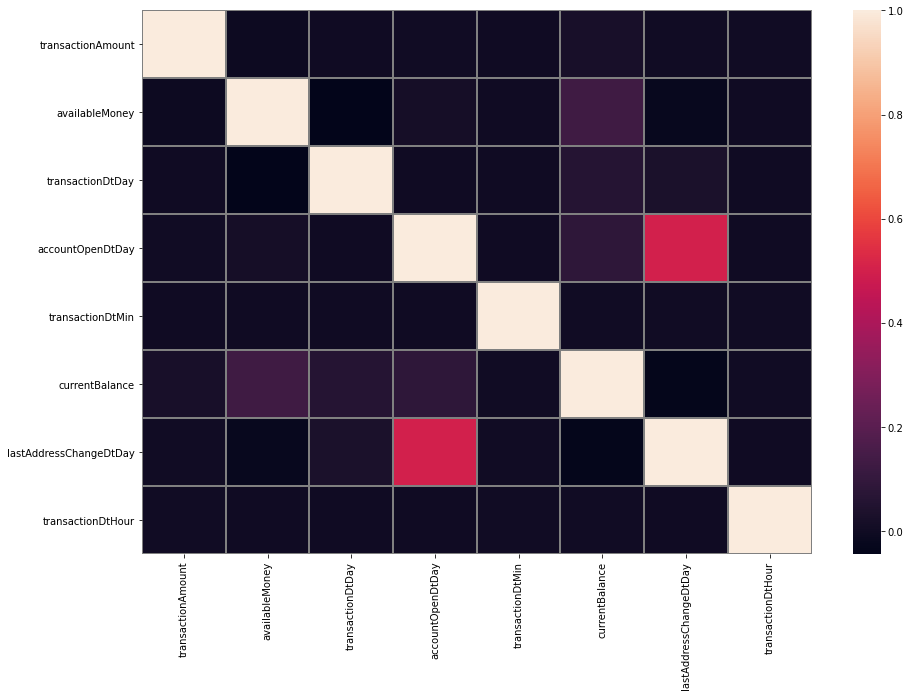

In [121]:
from seaborn import heatmap
import numpy as np

plt.rcParams['figure.figsize'] = (15,10)
temp = main_df.nunique()
columns_for_heatmap = set(temp.index[temp.values>20].values) - set(['customerId', 'accountNumber', 'cardCVV', 'enteredCVV', 'cardLast4Digits', 'merchantName'])
correlation_matrix = main_df[columns_for_heatmap].corr()
heatmap(correlation_matrix, xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns, linewidths=0.25, linecolor='grey')
plt.show()

# Training models:

My intuition is- companies lose more loyal customers $\approx 33\%$ due to blocked transactions. An excellent article by Stripe [here](https://stripe.com/guides/primer-on-machine-learning-for-fraud-protection).

On the other hand, fraudulent transactions going unnoticed could lead to potential lawsuits, operational dispute fees, etc.

A subtle line needs to be drawn and my main focus here is to reduce blocked-transactions of legitimate customers: $Type$-$II$ error. 



We can design the Null and Alternative Hypothesis as "A transaction is legitimate until proven otherwise":

> $H_0$ : The transaction is legit.

> $H_1$ : The transaction is fraudulent.

$Type$-$II$ error would be a $False$ $Negative:$ expected $H_0$ but wrongly predicted $H_1$.

### Defining the Feature-set and Label-set to derive the train-test splits

In [130]:
flip_binary = lambda x: 1 if x==0 else 0
main_df['isFraud'] = main_df['isFraud'].apply(flip_binary)
main_df['isFraud'].value_counts()

1    773946
0     12417
Name: isFraud, dtype: int64

In [131]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

feature_cols = set(main_df.columns) - set(['isFraud', 'cardCVV', 'enteredCVV', 'cardLast4Digits', 'accountNumber', 'customerId'])
labels = main_df['isFraud']
features = main_df[feature_cols]
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, stratify=labels)

In [132]:
def print_neat_metrics(expected, preds, model_name='Logistic-Regression', show_confusion_matrix=False):
    print(f'Precision = {round(100*precision_score(expected, preds),2)}%.')
    print(f'Recall = {round(100*recall_score(expected, preds),2)}%.')
    print(f'Accuracy = {round(100*accuracy_score(expected, preds),2)}%.')
    print(f'F1 score = {round(100*f1_score(expected, preds),2)}%.')
    
    if show_confusion_matrix:
        tn, fp, fn, tp = confusion_matrix(expected, preds).ravel()
        print(f'Confusion matrix for {model_name} model = \n\tTP={tp}  FN={fn}\n\tFP={fp}  TN={tn}\n')


In [133]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(n_jobs=-1, verbose=1).fit(x_train, y_train)
preds = logistic_model.predict(x_test)

print_neat_metrics(y_test, preds, 'baseline Logistic-Regression', True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   39.7s finished


Precision = 98.42%.
Recall = 100.0%.
Accuracy = 98.42%.
F1 score = 99.2%.
Confusion matrix for baseline Logistic-Regression model = 
	TP=77395  FN=0
	FP=1242  TN=0



### Logistic regression just predicts the majority class. 🤔

### Let's look also at Decision Tree, since Logistic Regression is essentially useless here

In [134]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier().fit(x_train, y_train)
preds = decision_tree.predict(x_test)

print_neat_metrics(y_test, preds, 'baseline Decision-Tree', True)

Precision = 98.67%.
Recall = 98.19%.
Accuracy = 96.92%.
F1 score = 98.43%.
Confusion matrix for baseline Decision-Tree model = 
	TP=75994  FN=1401
	FP=1024  TN=218



In [147]:
from sklearn.model_selection import StratifiedKFold
strat_kfold_cv = StratifiedKFold(n_splits=10, shuffle=True)



for train_i, test_i in strat_kfold_cv.split(features, labels):
    x_train, x_test = features.iloc[train_i], features.iloc[test_i]
    y_train, y_test = labels.iloc[train_i], labels.iloc[test_i]
    print(f'Train-stratification: {round(y_train.value_counts()[0]/y_train.count()*100,2)}%, Test-stratification: {round(y_test.value_counts()[0]/y_test.count()*100,2)}%')
    decision_tree.fit(x_train, y_train)
    preds = decision_tree.predict(x_test)
    print_neat_metrics(y_test, preds, 'baseline Decision-Tree', True)

Train-stratification: 1.58%, Test-stratification: 1.58%
Precision = 98.69%.
Recall = 98.25%.
Accuracy = 96.99%.
F1 score = 98.47%.
Confusion matrix for baseline Decision-Tree model = 
	TP=76040  FN=1355
	FP=1013  TN=229

Train-stratification: 1.58%, Test-stratification: 1.58%
Precision = 98.66%.
Recall = 98.09%.
Accuracy = 96.8%.
F1 score = 98.37%.
Confusion matrix for baseline Decision-Tree model = 
	TP=75915  FN=1480
	FP=1034  TN=208

Train-stratification: 1.58%, Test-stratification: 1.58%
Precision = 98.67%.
Recall = 98.18%.
Accuracy = 96.91%.
F1 score = 98.43%.
Confusion matrix for baseline Decision-Tree model = 
	TP=75989  FN=1406
	FP=1024  TN=218

Train-stratification: 1.58%, Test-stratification: 1.58%
Precision = 98.65%.
Recall = 98.17%.
Accuracy = 96.88%.
F1 score = 98.41%.
Confusion matrix for baseline Decision-Tree model = 
	TP=75978  FN=1417
	FP=1039  TN=202

Train-stratification: 1.58%, Test-stratification: 1.58%
Precision = 98.66%.
Recall = 98.22%.
Accuracy = 96.93%.
F1 sc

### Atleast now we get a practical prediction rather than just the majority class 🙂
On average baseline has a good $Recall$ ($True Positive Rate$) $\approx 98\%$, and equivalently a good $Precision$ $\approx 98\%$.

### Using a more complex Random-Forest model than baseline Logistic or Decision Tree
Isolation Forest is known to work well with highly-unbalanced sparse datasets (resembling Anomaly detection).

In [150]:
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators' : [50, 100, 200],
    'max_depth' : [5, None],
    'random_state' : [1],
    'min_samples_split' : [4],
    'n_jobs' : [-1]
}
random_forest = RandomForestClassifier()

cv_output = GridSearchCV(random_forest, param_grid=param_grid, cv=strat_kfold_cv, verbose=1).fit(features, labels)
cv_output

Fitting 10 folds for each of 6 candidates, totalling 60 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, None], 'min_samples_split': [4],
                         'n_estimators': [50, 100, 200], 'n_jobs': [-1],
                         'random_state': [1]},
             verbose=1)

In [163]:
print(f'Best random-forest after grid-search has n_trees: {cv_output.best_estimator_.n_estimators}, and max-depth of trees: {cv_output.best_estimator_.max_depth}')

for train_i, test_i in strat_kfold_cv.split(features, labels):
    x_train, x_test = features.iloc[train_i], features.iloc[test_i]
    y_train, y_test = labels.iloc[train_i], labels.iloc[test_i]
    preds = cv_output.best_estimator_.predict(x_test)
    print_neat_metrics(y_test, preds, 'Best Random-Forest', True)

Best random-forest after grid-search has n_trees: 100, and max-depth of trees: None
Precision = 99.51%.
Recall = 100.0%.
Accuracy = 99.52%.
F1 score = 99.76%.
Confusion matrix for Best Random-Forest model = 
	TP=77395  FN=0
	FP=378  TN=864

Precision = 99.49%.
Recall = 100.0%.
Accuracy = 99.5%.
F1 score = 99.74%.
Confusion matrix for Best Random-Forest model = 
	TP=77395  FN=0
	FP=396  TN=846

Precision = 99.52%.
Recall = 100.0%.
Accuracy = 99.52%.
F1 score = 99.76%.
Confusion matrix for Best Random-Forest model = 
	TP=77395  FN=0
	FP=376  TN=866

Precision = 99.54%.
Recall = 100.0%.
Accuracy = 99.54%.
F1 score = 99.77%.
Confusion matrix for Best Random-Forest model = 
	TP=77395  FN=0
	FP=360  TN=881

Precision = 99.54%.
Recall = 100.0%.
Accuracy = 99.55%.
F1 score = 99.77%.
Confusion matrix for Best Random-Forest model = 
	TP=77395  FN=0
	FP=357  TN=884

Precision = 99.55%.
Recall = 100.0%.
Accuracy = 99.56%.
F1 score = 99.78%.
Confusion matrix for Best Random-Forest model = 
	TP=7739

In [157]:
iso_forest = IsolationForest(n_jobs=-1)

for train_i, test_i in strat_kfold_cv.split(features, labels):
    x_train, x_test = features.iloc[train_i], features.iloc[test_i]
    y_train, y_test = labels.iloc[train_i], labels.iloc[test_i]
    iso_forest.fit(x_train, y_train)
    preds = iso_forest.predict(x_test)
    preds = np.where(preds==-1, 0, preds)
    print_neat_metrics(y_test, preds, 'Isolation-Forest', True)

Precision = 98.46%.
Recall = 83.21%.
Accuracy = 82.2%.
F1 score = 90.2%.
Confusion matrix for Isolation-Forest model = 
	TP=64403  FN=12992
	FP=1007  TN=235

Precision = 98.45%.
Recall = 79.42%.
Accuracy = 78.52%.
F1 score = 87.92%.
Confusion matrix for Isolation-Forest model = 
	TP=61466  FN=15929
	FP=965  TN=277

Precision = 98.46%.
Recall = 82.54%.
Accuracy = 81.54%.
F1 score = 89.8%.
Confusion matrix for Isolation-Forest model = 
	TP=63879  FN=13516
	FP=1001  TN=241

Precision = 98.42%.
Recall = 83.91%.
Accuracy = 82.84%.
F1 score = 90.59%.
Confusion matrix for Isolation-Forest model = 
	TP=64944  FN=12451
	FP=1043  TN=198

Precision = 98.46%.
Recall = 82.04%.
Accuracy = 81.06%.
F1 score = 89.5%.
Confusion matrix for Isolation-Forest model = 
	TP=63498  FN=13897
	FP=996  TN=245

Precision = 98.49%.
Recall = 82.25%.
Accuracy = 81.29%.
F1 score = 89.64%.
Confusion matrix for Isolation-Forest model = 
	TP=63657  FN=13738
	FP=976  TN=265

Precision = 98.48%.
Recall = 82.86%.
Accuracy =

### Random Forest seems to perform better than the theoretically better Isolation Forest

Random-Forest gives an excellent $Recall$ $\approx 99.9\%$, and great $Precision$ $\approx 98\%$.

> Essentially, it will **very rarely** falsely accuse a legitimate-transaction as being fraudulent (Type-II error).

Seems like a good candidate for final predictions.

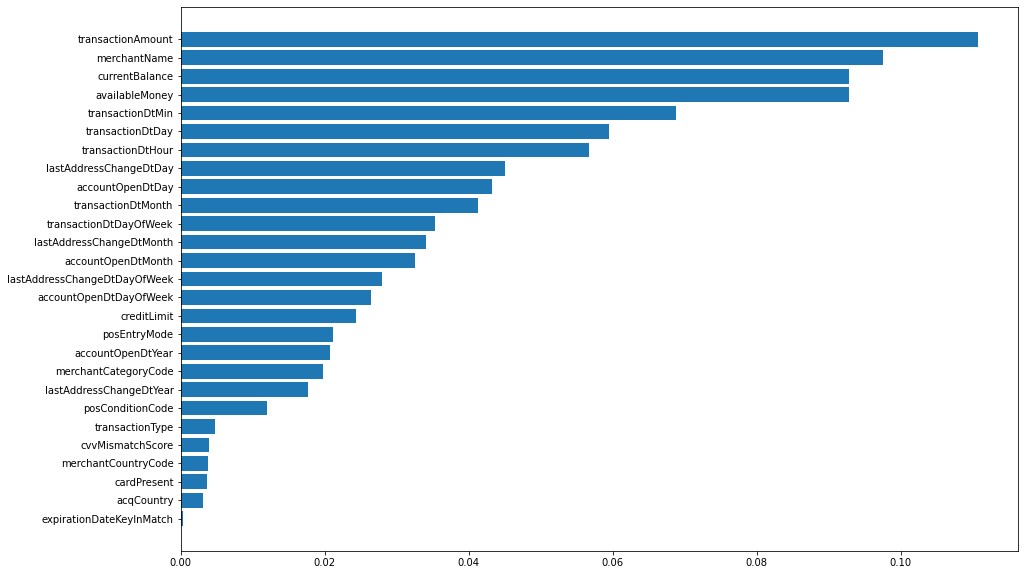

In [158]:
importances = pd.DataFrame(cv_output.best_estimator_.feature_importances_)
importances.index = features.columns
importances = importances.sort_values(by=0)
fig, ax = plt.subplots()
ax.barh(importances.index, importances.to_numpy().flatten())
plt.show()